In [99]:
from collections import defaultdict
import re

import numpy as np
import pandas as pd
import pysam
from Bio import SeqIO

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=14) 
plt.rc('figure', titlesize=16)
plt.rc('legend', fontsize=14)

# Часть 1: анализ ридов Illumina

In [3]:
def coverage(filepath, folder='./', title='', plotsize=5000):

    with pysam.AlignmentFile(folder + filepath, 'r') as pb:
        ref_length = pb.lengths[0]
        perbase_cov = np.zeros(ref_length)
        for column in pb.pileup():
            perbase_cov[column.pos] = column.n
    print(f'Mean coverage: {round(np.mean(perbase_cov), 2)}')
    print(f'{round(np.mean(perbase_cov != 0) * 100, 2)} % covered')

    fig, ax = plt.subplots(figsize=(10, 8))
    averaged_cov = np.array([np.mean(chunk) for chunk in np.array_split(perbase_cov, plotsize)])
    positions = np.arange(1, ref_length+1, ref_length // plotsize)
    positions = np.array([chunk[0] for chunk in np.array_split(np.arange(1, ref_length), plotsize)])
    sns.lineplot(x=positions, y=averaged_cov, ax=ax)
    ax.set_xlabel('Genome position')
    ax.set_ylabel('Coverage')
    plot_title = 'Coverage'
    if title:
        plot_title += ' - ' + title
    fig.suptitle(plot_title, fontsize=25)
    fig.tight_layout()   
    
def insert_size(filepath, folder='./', borders=(100, 300)):
    max_insert_size = 500  # больше - считаем за выбросы
    tlen = np.zeros(max_insert_size)
    with pysam.AlignmentFile(folder + filepath, 'r') as bam:
        for read in bam.fetch():
            insert_size = read.template_length
            if insert_size > 0:
                if insert_size < max_insert_size:
                    tlen[round(insert_size)] += 1
    # среднее значение
    total = 0
    n_reads = 0
    for insert_size, count in enumerate(tlen):
        total += insert_size * count
        n_reads += count
    mean_insert_size = total / n_reads
    print(f"Mean insert size = {round(mean_insert_size, 2)} bp")
    
    # квантили 
    s = 0
    q025 = None
    q975 = None
    for insert_size, count in enumerate(tlen):
        s += insert_size * count
        if q025 is None and s / total > 0.025:
            q025 = insert_size
        if q975 is None and s / total > 0.975:
            q975 = insert_size
    print(f'95% interval = {q025, q975}')
    
    fig, ax = plt.subplots(figsize=(8, 6), )
    sns.lineplot(x=np.arange(max_insert_size), y=tlen, ax=ax,)
    yticks = ax.get_yticks()
    ymin = 0
    ymax = yticks[-2]
    
    ax.vlines([q025, q975], ymin, ymax, color='red', label='95% interval')
    
    ax.set_xlabel('Insert size')
    ax.set_xlim(*borders)
    ax.legend()
    fig.suptitle('Insert size distribution')
    fig.tight_layout()
    
def errors(filepath, folder='./'):
    cigar_operations = 'MIDNSHP=X'
   
    error_percentage = np.zeros(100)
    substitutions = {base: {} for base in 'ATGC'}
    for i in 'ATGC':
        for j in 'ATGC':
            substitutions[i][j] = 0
            
    with pysam.AlignmentFile(folder + filepath, 'rb') as pb:
        for read in pb.fetch():
            try:
                ref = read.get_reference_sequence()
            except ValueError:  # MD tag not present; read.cigartuples is None
                continue
            query = read.query_sequence
            ref_position = 0
            query_position = 0
            error_count = 0
            for i, size in read.cigartuples:
                op = cigar_operations[i]
                if op == 'M':
                    for i in range(size):
                        refb = ref[ref_position + i].upper() 
                        queryb = query[query_position + i].upper()
                        if refb != queryb and queryb != 'N':
                            substitutions[refb][queryb] += 1
                    ref_position += size
                    query_position += size
                elif op == 'I':
                    query_position += size
                    error_count += size
                elif op == 'D':
                    ref_position += size
                    error_count += size
                elif op == 'N':
                    ref_position += size
                elif op == 'S':
                    query_position += size
                elif op in 'HP':
                    pass
                elif op == '=':
                    query_position += size
                    ref_position += size
                elif op == 'X':
                    for i in range(size):
                        refb = ref[ref_position + i].upper() 
                        queryb = query[query_position + i].upper()
                        substitutions[refb][queryb] += 1
                    ref_position += size
                    query_position += size
                    error_count += size
                
            read_length = len(read.query_sequence)
            error_percent = round(error_count / read_length * 100)
            error_percentage[error_percent] += 1
    # средний процент ошибок в ридах
    total = 0
    n_reads = 0
    for i, count in enumerate(error_percentage):
        n_reads += count
        percent = i + 1
        total += percent * count
    print(f'Mean error percent: {round(total / n_reads, 2)}%')
        
    tmp = pd.DataFrame(substitutions)
    print('Substituiton frequencies')
    display(tmp)

### Dataset 1 (100x)

```bash
bwa index MG1655-K12.fasta
bwa mem -t 8 MG1655-K12.fasta 100x.1.fastq 100x.2.fastq | samtools view -b | samtools sort --threads 8 > 100x.bam
samtools index 100x.bam
samtools flagstat 100x.bam
```
99.57% mapped

Mean coverage: 104.98
100.0 % covered
Mean insert size = 215.32 bp
95% interval = (197, 235)
Mean error percent: 1.0%
Substituiton frequencies


,A,T,G,C
A,0,146392,159165,272766
T,145879,0,273569,157971
G,380536,637018,0,240021
C,637340,379576,241260,0


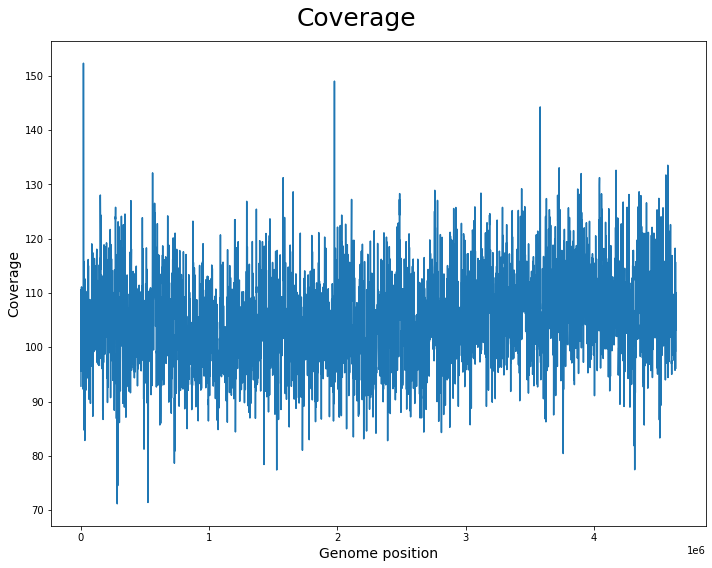

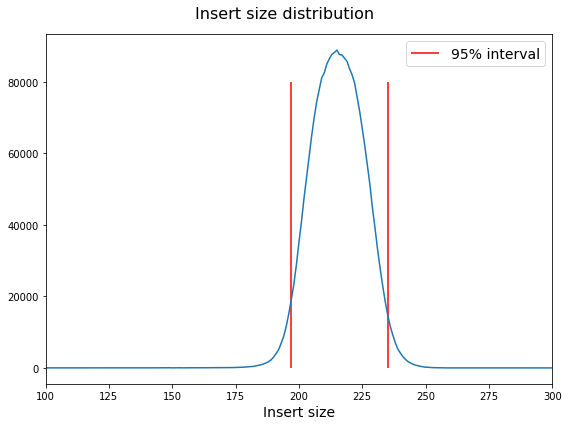

In [31]:
file = '100x.bam'
coverage(file)
insert_size(file)
errors(file)

### Dataset 2 (ecoli_mda_lane1)

```bash
bwa mem -t 8 MG1655-K12.fasta ecoli_mda_lane1_left.downsampled.fastq ecoli_mda_lane1_right.downsampled.fastq | samtools view -b | samtools sort --threads 8 > ecoli_mda.bam
samtools index ecoli_mda.bam
samtools flagstat ecoli_mda.bam
```
97.23% mapped

Mean coverage: 109.34
96.14 % covered
Mean insert size = 258.83 bp
95% interval = (120, 331)
Mean error percent: 1.0%
Substituiton frequencies


,A,T,G,C
A,0,170484,175292,282325
T,168701,0,277775,175039
G,377452,604279,0,219035
C,616014,381060,223138,0


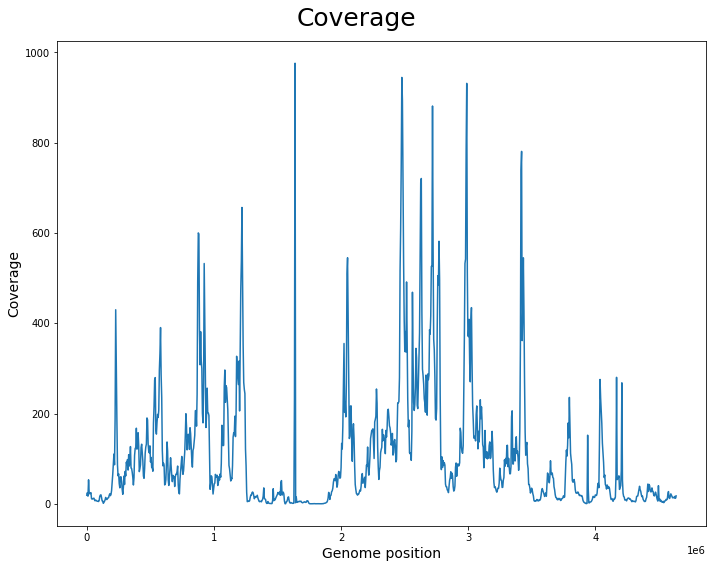

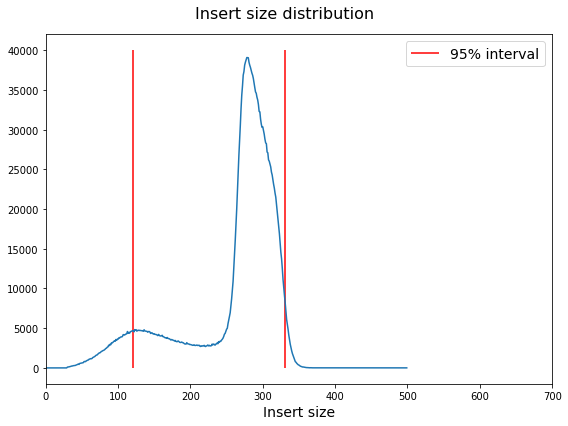

In [4]:
file = 'ecoli_mda.bam'
coverage(file, plotsize=1000)
insert_size(file, borders=(0, 700))
errors(file)

# Часть 2: анализ ридов Ion Torrent

In [6]:
ls

100x.bam         test.bam.bai              test_reference.fasta.bwt
B22-730.fastq    test.fastq                test_reference.fasta.pac
C24-698.fastq    test_reference.fasta      test_reference.fasta.sa
DH10B-K12.fasta  test_reference.fasta.amb
test.bam         test_reference.fasta.ann


In [19]:
with op

100x.bam         test.bam.bai              test_reference.fasta.bwt
B22-730.fastq    test.fastq                test_reference.fasta.pac
C24-698.fastq    test_reference.fasta      test_reference.fasta.sa
DH10B-K12.fasta  test_reference.fasta.amb
test.bam         test_reference.fasta.ann


In [23]:
ls

B22-730.fastq    DH10B-K12.fasta.amb  test_reference.fasta
B22.bam          DH10B-K12.fasta.ann  test_reference.fasta.amb
B22.bam.bai      DH10B-K12.fasta.bwt  test_reference.fasta.ann
C24-698.fastq    DH10B-K12.fasta.pac  test_reference.fasta.bwt
C24.bam          DH10B-K12.fasta.sa   test_reference.fasta.pac
C24.bam.bai      test.bam             test_reference.fasta.sa
commands.sh      test.bam.bai
DH10B-K12.fasta  test.fastq


In [110]:
def iontorrent_stats(path):
    # за ошибки считаем мисматчи и инделы
    alphabet = 'ATGC_'
    substitutions = {n: dict() for n in alphabet}
    
    error_percentage = np.zeros(100)
    indel_length = np.zeros(30)
    mismatch_quality = defaultdict(int)
    indel_quality = defaultdict(int)
    
    for rbase in alphabet:
        for qbase in alphabet:
            substitutions[rbase][qbase] = 0
    cigar_operations = 'MIDNSHP=X'
    
    with pysam.AlignmentFile(path, 'rb') as bam:
        for read in bam.fetch():
            try:
                ref = read.get_reference_sequence()
            except ValueError:  # MD tag not present; read.cigartuples is None
                continue
                
                
            query = read.query_sequence
            quality = read.query_qualities
            ref_position = 0
            query_position = 0
            error_count = 0
            for i, size in read.cigartuples:
                op = cigar_operations[i]
                if op == 'M':
                    for i in range(size):
                        refb = ref[ref_position + i].upper() 
                        queryb = query[query_position + i].upper()
                        if refb != queryb and queryb != 'N':
                            mismatch_quality[quality[query_position + i]] += 1
                            substitutions[refb][queryb] += 1
                            error_count += 1
                    ref_position += size
                    query_position += size
                elif op == 'I':
                    for i in range(size):
                        queryb = query[query_position + i].upper()
                        indel_quality[quality[query_position + i]] += 1
                        substitutions['_'][queryb] += 1
                    query_position += size
                    indel_length[size] += 1
                    error_count += size
                elif op == 'D':
                    for i in range(size):
                        refb = ref[ref_position + i].upper()
                        substitutions[refb]['_'] += 1
                    ref_position += size
                    indel_length[size] += 1
                    error_count += size
                elif op == 'N':
                    ref_position += size
                elif op == 'S':
                    query_position += size
                elif op in 'HP':
                    pass
                elif op == '=':
                    query_position += size
                    ref_position += size
                elif op == 'X':
                    for i in range(size):
                        refb = ref[ref_position + i].upper() 
                        queryb = query[query_position + i].upper()
                        substitutions[refb][queryb] += 1
                        mismatch_quality[quality[query_position + i]] += 1
                    ref_position += size
                    query_position += size
                    error_count += size
                
            read_length = read.infer_query_length() # len(read.query_sequence)
            error_percent = round(error_count / read_length * 100)
            
            error_percentage[error_percent] += 1
                
    # средний процент ошибок
    total = 0
    n_reads = 0
    for percent, count in enumerate(error_percentage):
        n_reads += count
        total += percent * count
    mean_error_percent = total / n_reads
    print(f'Mean error percent = {round(mean_error_percent, 2)}%')
    
    # распределение длин инделов
    fig, ax = plt.subplots()
    ax.bar(np.arange(29) + 1, indel_length[1:], )
    ax.set_yscale('log')
    ax.set_ylabel('$\lg$(count)')
    ax.set_xlabel('length')
    ax.grid()
    fig.suptitle('Indel length distribution')
    
    # таблица замен
    substitutions = pd.DataFrame(substitutions)
    display(substitutions.style.set_caption('Subtitution/indel frequency'))
    
    # качество инделов
    indel_quality = np.array(sorted(indel_quality.items()))
    fig, ax = plt.subplots()
    ax.bar(indel_quality[:, 0], indel_quality[:, 1])
    ax.set_xlabel('Phred quality')
    ax.set_ylabel('Count')
    ax.grid()
    fig.suptitle('Indel quality distribution')
    fig.tight_layout()
    
    # качество мисматчей
    mismatch_quality = np.array(sorted(mismatch_quality.items()))
    fig, ax = plt.subplots()
    ax.bar(mismatch_quality[:, 0], mismatch_quality[:, 1])
    ax.set_xlabel('Phred quality')
    ax.set_ylabel('Count')
    ax.grid()
    fig.suptitle('Mismatch quality distribution')
    fig.tight_layout()
    
def homopolymer_indel_percent(alignment, reference, folder, k=5):   
    """
    Count % of indels that are near homopolymers with >= k similar bases
    """
    cigar_field_pattern = re.compile('|'.join([f'([0-9]+{field})' for field in 'MIDNSHP=X']))
    with open(folder + reference, 'r') as f:
        genome = ''.join(line.strip() for line in f.readlines()[1:])
    genome_length = len(genome)
    total_indels = 0
    homop_indels = 0
    
    def find_homop_size(current_genome_index):
        
        homop_size = 1
        ref_base = genome[current_genome_index]
        
        # check positions before indel
        i = current_genome_index - 1
        while genome[i] == ref_base and i >= 0:
            homop_size += 1
            i -= 1

        # check positions after indel
        i = current_genome_index + 1
        while genome[i] == ref_base and i <= genome_length - 1:
            homop_size += 1
            i += 1
        return homop_size
    
    with open(folder + alignment, 'r') as f:
        
        for line in f:
            if line.startswith('@'):
                continue
    
            line = line.split('\t')
            cigar = line[5]
            seq = line[9]
            qual = line[10]
            
            read_length = len(seq)
            errors = 0
            
            genome_index = int(line[3]) - 1 
            read_index = 0
            
            for match in re.findall(cigar_field_pattern, cigar):

                match = ''.join(match)
                code = match[-1]
                size = int(match[:-1])
                
                # alignment match
                if code == 'M':  
                    genome_index += size
                    read_index += size
                # insertion to the reference
                elif code == 'I': 
                    homop_size = find_homop_size(genome_index)
                    total_indels += 1
                    if homop_size >= k:
                        homop_indels += 1
                        
                    read_index += size        
                # soft clipping; nucleotides present in SEQ
                elif code == 'S':  
                    read_index += size
                # deletion from the reference 
                elif code == 'D':
                    homop_size = find_homop_size(genome_index)
                    total_indels += 1
                    if homop_size >= k:
                        homop_indels += 1
                    genome_index += size
                # splicing
                elif code == 'N':
                    genome_index += size
                # hard clipping/padding
                elif code in 'HP':
                    pass
                elif code == '=':  # sesquence match
                    read_index += size
                    genome_index += size
                elif code == 'X':  # sequence mismatch
                    read_index += size
                    genome_index += size
                    
        print((f'{round(100 * homop_indels / total_indels)}% of all indels are next to '
               f'homopolymear fragments longer then {k} b.p.'))

## B22-730.fastq

```bash
bwa index DH10B-K12.fasta
bwa mem -t 8 DH10B-K12.fasta B22-730.fastq | samtools view -b | samtools sort --threads 8 > B22.bam
samtools index B22.bam
samtools flagstat B22.bam
```
98.41% mapped

Mean coverage: 34.03
99.99 % covered
Mean error percent = 0.72%


,A,T,G,C,_
A,0,11325,17215,10360,183228
T,11173,0,10563,16671,184506
G,23657,9060,0,8092,79197
C,9147,24493,7209,0,79059
_,119254,119372,72804,72479,0


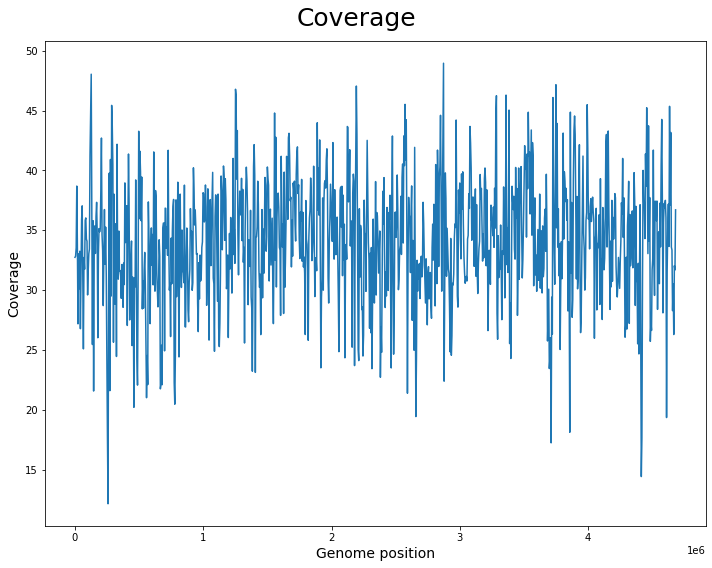

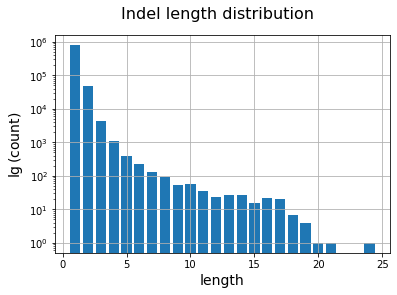

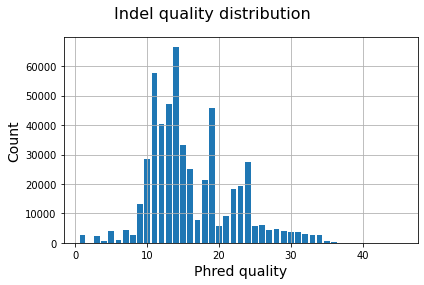

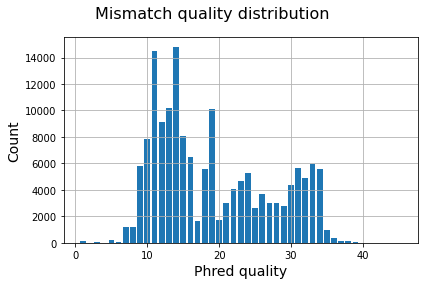

In [103]:
file = 'B22.bam'
coverage(file, plotsize=1000)
iontorrent_stats(file)

```bash
bwa mem -t 8 DH10B-K12.fasta B22-730.fastq > B22.sam
```

In [105]:
reference = 'DH10B-K12.fasta'
homopolymer_indel_percent('B22.sam', reference, './')

13% of all indels are next to homopolymear fragments longer then 5 b.p.


## C24-698.fastq

```bash
bwa mem -t 8 DH10B-K12.fasta C24-698.fastq | samtools view -b | samtools sort --threads 8 > C24.bam
samtools index C24.bam
samtools flagstat C24.bam
```
99.41% mapped

Mean coverage: 35.7
100.0 % covered
Mean error percent = 0.34%


,A,T,G,C,_
A,0,6549,14257,6751,80749
T,6488,0,7069,13966,81446
G,21938,5248,0,5380,46631
C,5124,22450,4978,0,47601
_,37199,37728,82142,82132,0


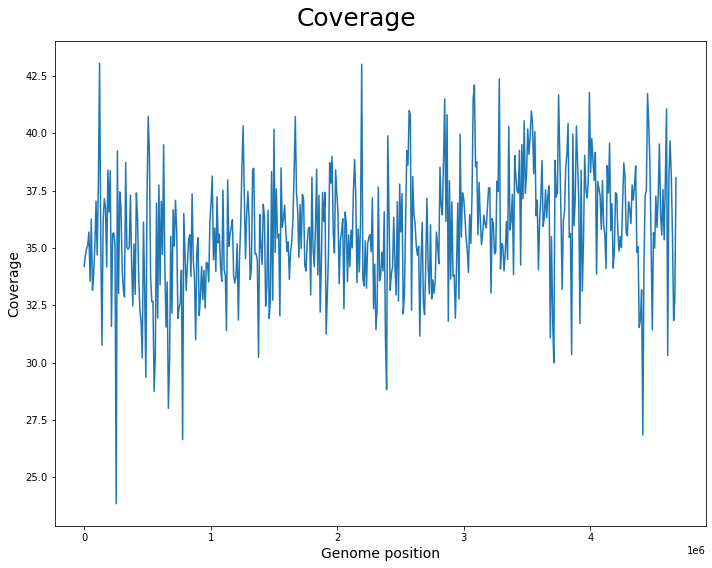

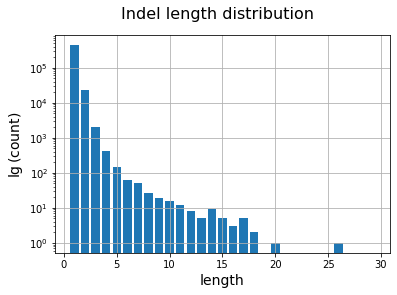

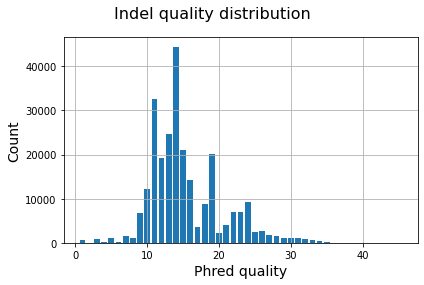

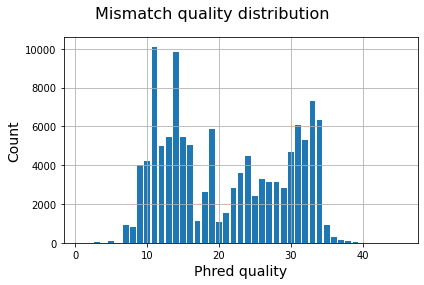

In [111]:
file = 'C24.bam'
coverage(file, plotsize=500)
iontorrent_stats(file)

```bash
bwa mem -t 8 DH10B-K12.fasta C24-698.fastq > C24.sam
```

In [112]:
homopolymer_indel_percent('C24.sam', reference, './')

7% of all indels are next to homopolymear fragments longer then 5 b.p.
